# Import libraries

In [1]:
import numpy as np
import uproot as up
import awkward as ak
from matplotlib import pyplot as plt
from scipy.stats import binned_statistic_dd
import mplhep as hep
from matplotlib.colors import TwoSlopeNorm
from matplotlib.ticker import LogLocator, ScalarFormatter
from collections import namedtuple

hep.style.use("CMS")

# Load data

In [2]:
ScaleFactors = namedtuple('ScaleFactors', ['pt_sfs', 'mass_sfs', 'bin_edges', 'counts'])
Thresholds = namedtuple('Thresholds', ['l1_pt', 'l1_mass', 'gen_pt', 'gen_mass'])

class Jet:

    required_variables = ["pt", "eta", "mass", "genpt", "genmass", "event"]    # variables required for the class to function
    l1_vars = ["pt", "eta", "mass"]    # variables to bin on
    # l1_vars = ["pt", "eta"]    # variables to bin on
    
    def __init__(self, path: str, branch: str = "outnano/Jets",
                 keys: dict = {"jet_pt": "pt", "jet_eta_phys": "eta", "jet_mass": "mass", "jet_genmatch_pt": "genpt", "jet_genmatch_mass": "genmass", "event": "event"}):
        for v in Jet.required_variables:
            if v not in list(keys.values()): raise Exception("A required variable is not defined in keys!")
        self.data = self.load(path, branch, keys)


    @staticmethod
    def load(path, branch, keys):
        print("Loading data...")
        with up.open(path)[branch] as file:
            data = file.arrays( filter_name=list( keys.keys() ) )
            reject_mask = file["jet_reject"].array() == False if "jet_reject" in file.keys() else ak.ones_like(data["event"], dtype=bool)
        
        data = ak.Array({keys[field]: data[field] for field in data.fields})[reject_mask]
        print("Data loaded!\n")
        return data


    @staticmethod
    def preprocess(data, eta_limit: int = 5.0, l1_pt_range: tuple[float, float] = (0., 0.), l1_mass_range: tuple[float, float] = (0., 0.),
                   gen_pt_range: tuple[float, float] = (0., 1000.), gen_mass_range: tuple[float, float] = (0., 182.)
                   ) -> ak.highlevel.Array:
        
        # filter out gen masses outside of range
        mask = (data["genmass"] > gen_mass_range[0]) & (data["genmass"] < gen_mass_range[1])
        mask = mask & ( data["genpt"] > gen_pt_range[0]) & (data["genpt"] < gen_pt_range[1] )
        
        mask = mask & ( data["mass"] > l1_mass_range[0]) & (data["mass"] < l1_mass_range[1] )
        mask = mask & ( data["pt"] > l1_pt_range[0]) & (data["pt"] < l1_pt_range[1] )

        mask = mask & (abs(data["eta"]) < eta_limit)
        return data[mask]
    

    @staticmethod
    def test_train_split(data, train_ratio = 0.75):
        data = data[ np.random.permutation(len(data)) ]
        splitIdx = int(len(data) * train_ratio)
        data_train, data_test = data[:splitIdx], data[splitIdx:]
        return data_train, data_test
    

    @staticmethod
    def response(data_train, eps = 1e-3):
        pt_response = (data_train["pt"] + eps) / (data_train["genpt"] + eps)
        mass_response = (data_train["mass"] + eps) / (data_train["genmass"] + eps)
        return pt_response, mass_response
    

    @staticmethod
    def histogram( data_train: ak.highlevel.Array, pt_response: ak.highlevel.Array, mass_response: ak.highlevel.Array,
        nBins: int = 100, nans: int = 1, how: str = "mean" ) -> tuple[np.ndarray, np.ndarray, np.ndarray, np.ndarray, np.ndarray]:

        bin_edges = []
        vals = []
        for v in Jet.l1_vars:
            if (v == "pt") | (v=="mass"):
                values = ak.to_numpy(data_train[v])
                vals.append( values )
                bin_edges.append( np.unique( np.quantile(values, np.linspace(0, 1, nBins + 1)) ) )
            elif v == "eta":
                vals.append( ak.to_numpy(data_train["eta"]) )
                bin_edges.append( np.linspace(-5, 5, 11) )
            else:
                raise Exception("Invalid variable in l1_vars!")

        train_numpy = np.column_stack(vals)

        pt_resp = binned_statistic_dd( train_numpy, ak.to_numpy(pt_response), statistic = how, bins = bin_edges )[0]
        mass_resp = binned_statistic_dd( train_numpy, ak.to_numpy(mass_response), statistic = how, bins = bin_edges )[0]

        counts = binned_statistic_dd(
            train_numpy, np.ones(len(train_numpy)),
            statistic='count', bins=bin_edges
        )[0]
        
        pt_sf = 1 / np.nan_to_num(pt_resp, nan=nans)
        mass_sf = 1 / np.nan_to_num(mass_resp, nan=nans)
        return ScaleFactors(pt_sf, mass_sf, bin_edges, counts)
        # return pt_sf, mass_sf, bin_edges, counts
    

    @staticmethod
    def apply_scale_factors(data_test, scale_factors: ScaleFactors):
        pt_scalefactors, mass_scalefactors, bin_edges, _ = scale_factors

        bin_idx = [ np.digitize(ak.to_numpy(data_test[var]), bin_edges[i]) - 1 for i, var in enumerate(Jet.l1_vars) ]
        bin_idx = np.stack(bin_idx, axis=-1)

        # check that jet falls into a valid, predefined bin
        valid = np.all( [(0 <= bin_idx[:, i]) & (bin_idx[:, i] < len(bin_edges[i]) - 1) for i in range(len(Jet.l1_vars))], axis=0 )

        # initialize output and assign values from mean_values
        pt_output, mass_output = np.ones( len(data_test) ), np.ones( len(data_test) )
        pt_output[valid] = pt_scalefactors[ tuple(bin_idx[valid].T) ]    # where jet falls into a valid bin, assign the scale factor
        mass_output[valid] = mass_scalefactors[ tuple(bin_idx[valid].T) ]    # where jet falls into a valid bin, assign the scale factor
        
        pt_corr, mass_corr = data_test["pt"] * pt_output, data_test["mass"] * mass_output
        data_test["pt_corr"], data_test["mass_corr"] = pt_corr, mass_corr
        return data_test, pt_corr, mass_corr


    def get_scale_factors(self, **params):
        data = self.data
        self.params = params

        eta_limit = params["eta_limit"]
        gen_pt_range = params["gen_pt_range"]
        gen_mass_range = params["gen_mass_range"]
        l1_pt_range = params["l1_pt_range"]
        l1_mass_range = params["l1_mass_range"]
        nBins = params["nBins"]
        nans = params["nans"]
        train_ratio = params["train_ratio"]
        how = params["how"]
        eps = params["eps"]

        print("Shuffling jets and splitting into test and train...")
        train, test = self.test_train_split(data, train_ratio=train_ratio)
        print("Jets shuffled and split!\n")

        print("Preprocessing data...")
        train = self.preprocess(train, eta_limit=eta_limit, 
                               l1_pt_range=l1_pt_range, gen_pt_range=gen_pt_range,
                               l1_mass_range=l1_mass_range, gen_mass_range=gen_mass_range)
        print("Data preprocessed!\n")

        print("Calculating response of each jet from training data...")
        pt_response, mass_response = self.response(train, eps=eps)
        print("Responses calculated!\n")

        print("Histogramming responses, calculating mean of each bin, and determining scale factor as inverse of mean response...")
        scale_factors = self.histogram(train, pt_response, mass_response, nBins=nBins, nans=nans, how=how)
        print("Scale factors calculated!\n")

        return test, scale_factors

def groupby_event(data):
    sorted_arr = data[ak.argsort( data["event"]) ]
    counts = ak.run_lengths(sorted_arr.event)
    data_grouped = ak.unflatten(sorted_arr, counts)
    return data_grouped

In [3]:
path = "./data/sc8Jets.root"
jets = Jet(path)

Loading data...


Data loaded!



In [4]:
params = {
    "eta_limit": 5.0,
    "gen_pt_range": (0., 2047.),    # only keep jets where true pt is in dynamic range of l1 value
    "gen_mass_range": (0., 181.),    # only keep jets where true mass is in dynamic range of l1 value
    "l1_pt_range": (0., 2047.),    # must be from 0 so bins over all of l1 pt 
    "l1_mass_range": (0., 181.),    # must be from 0 so bins over all of l1 mass
    "nBins": 51,    # bin granularity
    "nans": 1,
    "train_ratio": 0.70,
    "how": "median",
    "eps": 1e-3
}

test, scale_factors = jets.get_scale_factors(**params)

Shuffling jets and splitting into test and train...
Jets shuffled and split!

Preprocessing data...
Data preprocessed!

Calculating response of each jet from training data...
Responses calculated!

Histogramming responses, calculating mean of each bin, and determining scale factor as inverse of mean response...
Scale factors calculated!



In [446]:

class Plot:
    
    scale = {
        "figure": 10.8,
        "title": 22,
        "label": 22,
        "legend": 16,
        "ticks": 20
    }
    cols = ["tab:blue", "tab:orange", "tab:green", "tab:red", "tab:purple"]

    def __init__(self, jets: ak.highlevel.Array, scale_factors: ScaleFactors, thresholds: Thresholds = Thresholds(-9,-9,-9,-9)):
        self.scale_factors = scale_factors
        self.thresholds = thresholds

        if isinstance(thresholds.l1_pt, tuple):    # bounds not limits
            mask = (jets.genpt > thresholds.gen_pt[0]) & (jets.genpt < thresholds.gen_pt[1])
            mask = mask & (jets.genmass > thresholds.gen_mass[0]) & (jets.genmass < thresholds.gen_mass[1])
            mask = mask & (jets.pt > thresholds.l1_pt[0]) & (jets.pt < thresholds.l1_pt[1])
            mask = mask & (jets.mass > thresholds.l1_mass[0]) & (jets.mass < thresholds.l1_mass[1])
        else:
            mask = (jets.genpt > thresholds.gen_pt) & (jets.genmass > thresholds.gen_mass)
            mask = mask & (jets.pt > thresholds.l1_pt) & (jets.mass > thresholds.l1_mass)
        
        self.jets = jets[mask]
        self.jets, _, _ = Jet.apply_scale_factors(self.jets, scale_factors)
        self.jets["pt_resp"] = self.jets["pt"] / self.jets["genpt"]
        self.jets["mass_resp"] = self.jets["mass"] / self.jets["genmass"]
        self.jets["pt_resp_corr"] = self.jets["pt_corr"] / self.jets["genpt"]
        self.jets["mass_resp_corr"] = self.jets["mass_corr"] / self.jets["genmass"]

    @staticmethod
    def boxplot(jets):
        _, (ax_pt, ax_mass) = plt.subplots(2, 1, figsize=(Plot.scale["figure"], Plot.scale["figure"]))

        def _make_bp(ax, variable, factor=3):
            raw, corr = jets[f"{variable}_resp"], jets[f"{variable}_resp_corr"]
            resp_mask = abs(raw) < factor#) & (abs(corr) < factor)
            vp = ax.violinplot([raw[resp_mask], corr[resp_mask]], vert=False, showextrema=False)

            for pc, c in zip(vp['bodies'], Plot.cols):
                pc.set_facecolor(c)
                pc.set_alpha(1.0)
                pc.set_edgecolor('black')
                pc.set_linewidth(0.0)

            bp = ax.boxplot([raw, corr],
                vert=False, tick_labels=["Raw", "Corrected"], sym="x", widths=0.6,
                showmeans=True, meanline=True, medianprops={"linestyle": "-"}, meanprops={"linestyle": ":"},
                showfliers=False)
            for median, c in zip(bp["medians"], Plot.cols):
                median.set_color("black")
                median.set_linewidth(1.0)
            for mean, c in zip(bp["means"], Plot.cols):
                mean.set_color("black")
                mean.set_linewidth(1.0)

            if variable == "mass": xlab = r"$\frac{M^{L1}}{M^{Gen}}$"
            elif variable == "pt": xlab = r"$\frac{p_{T}^{L1}}{p_{T}^{Gen}}$"
            else: raise Exception("Invalid variable for boxplot!")
            ax.set_xlabel(xlab, fontsize=Plot.scale["label"])
            return ax
        
        ax_pt, ax_mass = _make_bp(ax_pt, "pt"), _make_bp(ax_mass, "mass")
        for ax in (ax_pt, ax_mass):
            ax.set_xlim([-0.1, 2.2])
            ax.set_xticks(np.linspace(0, 2, 9))
            ax.invert_yaxis()
            hep.cms.label(ax=ax, llabel = "Phase-2 Simulation Preliminary", rlabel = "200 PU (14 TeV)", fontsize=Plot.scale["title"])
            ax.grid()
            ax.legend()

        plt.tight_layout()
        plt.show()

    @staticmethod
    def histogram(jets, nBins: int = 201, rng: tuple[float, float] = (0.0, 5.0)):
        _, (ax_pt, ax_mass) = plt.subplots(2, 1, figsize=(Plot.scale["figure"], Plot.scale["figure"]))

        def _make_hist(ax, variable, nBins=201, rng=(0.0, 5.0)):
            ax.hist(jets[f"{variable}_resp"], bins=nBins, range=rng, histtype='step', label="Raw", color="tab:blue")
            ax.hist(jets[f"{variable}_resp_corr"], bins=201, range=rng, histtype='step', label="Corrected", color="tab:orange")
            ax.axvline(np.median(jets[f"{variable}_resp"]), linestyle='--', label=f"Raw Median: {np.median(jets[f'{variable}_resp']):.3f}", color="tab:blue")
            ax.axvline(np.mean(jets[f"{variable}_resp"]), linestyle=':', label=f"Raw Mean: {np.mean(jets[f'{variable}_resp']):.3f}", color="tab:blue")
            ax.axvline(np.median(jets[f"{variable}_resp_corr"]), linestyle='--', label=f"Corrected Median: {np.median(jets[f'{variable}_resp_corr']):.3f}", color="tab:orange")
            ax.axvline(np.mean(jets[f"{variable}_resp_corr"]), linestyle=':', label=f"Corrected Mean: {np.mean(jets[f'{variable}_resp_corr']):.3f}", color="tab:orange")

            if variable == "mass": xlab = r"$\frac{M^{L1}}{M^{Gen}}$"
            elif variable == "pt": xlab = r"$\frac{p_{T}^{L1}}{p_{T}^{Gen}}$"
            else: raise Exception("Invalid variable for histogram!")
            ax.set_xlabel(xlab, fontsize=Plot.scale["label"])
            return ax

        ax_pt, ax_mass = _make_hist(ax_pt, "pt", nBins=nBins, rng=rng), _make_hist(ax_mass, "mass", nBins=nBins, rng=rng)
        for ax in (ax_pt, ax_mass):            
            hep.cms.label(llabel = "Phase-2 Simulation Preliminary", rlabel = "200 PU (14 TeV)", fontsize=Plot.scale["title"], ax=ax)
            ax.set_xlim([-0.1, 2.2])
            ax.set_xticks(np.linspace(0, 2, 9))
            ax.grid()
            ax.legend(fontsize=Plot.scale["legend"])

        plt.tight_layout()
        plt.show()

    @staticmethod
    def scale_factors_heatmap(edges, region: str = "barrel", **scale_factors):
        """
        Function assumes three variables in edges: pt, eta, mass
        """
        _, axs = plt.subplots(len(scale_factors), 1, figsize=(Plot.scale["figure"], Plot.scale["figure"]*1.25))
        pt_edges, eta_edges, mass_edges = edges
        eta_centers  = 0.5 * (eta_edges[1:]  + eta_edges[:-1])
        if region == "barrel": eta_mask = (eta_centers >= -2.5) & (eta_centers <= 2.5)
        elif region == "endcap": eta_mask = ( (eta_centers < -2.5) | (eta_centers > 2.5) )
        else: raise Exception("Invalid region specified for heatmap!")

        def _make_hm(ax, sf, var=None):
            heat_mean = np.mean(sf[:, eta_mask, :], axis=1)  # shape (pt_bins, mass_bins)

            ax.set_xscale("log")
            ax.set_yscale("log")

            ax.set_xlim(10, 1000)
            ax.set_ylim(1, 180)

            ax.xaxis.set_major_locator(LogLocator(base=10))
            ax.yaxis.set_major_locator(LogLocator(base=10))

            ax.xaxis.set_major_formatter(ScalarFormatter())
            ax.yaxis.set_major_formatter(ScalarFormatter())
            ax.ticklabel_format(style='plain')

            ax.set_xticks([10, 20, 40, 80, 160, 320, 640])
            ax.set_yticks([1, 2, 4, 8, 16, 32, 64, 128])
            # set axis tick font size
            ax.tick_params(axis='x', labelsize=Plot.scale["ticks"])
            ax.tick_params(axis='y', labelsize=Plot.scale["ticks"])

            # Labels
            ax.set_xlabel("$p_{T}^{L1}$ (GeV)", fontsize=Plot.scale["label"])
            ax.set_ylabel("$M^{L1}$ (GeV)", fontsize=Plot.scale["label"])

            my_cmap = plt.get_cmap('coolwarm').copy()
            my_cmap.set_bad(color='white')
            hm = ax.pcolormesh(pt_edges, mass_edges, heat_mean.T,
                norm=TwoSlopeNorm(vcenter=1, vmin=0, vmax=2.5),
                cmap=my_cmap, shading="auto"
            )
            if var == "pt": lab = f"$p_{{T}}^{{L1}}$ scale factor ({region})"
            elif var == "mass": lab = f"$M^{{L1}}$ scale factor ({region})"
            else: lab = "Scale factor"
            plt.colorbar(hm, label=lab, ax=ax)
            return ax

        for ax, (var, sf) in zip(axs, scale_factors.items()):
            ax = _make_hm(ax, sf, var)
            hep.cms.label(llabel = "Phase-2 Simulation Preliminary", rlabel = "200 PU (14 TeV)", fontsize=Plot.scale["title"]*0.9, ax=ax)
            ax.grid()
        
        plt.tight_layout()
        plt.show()

    @staticmethod
    def response_plot(jets, metric="mean"):
        _, axs = plt.subplots(2, 2, figsize=(Plot.scale["figure"]*1.75, Plot.scale["figure"]*1.4))
        
        def _bin_response(var, nBins=101):
            if var == "pt":
                gen = jets["genpt"]
                bins = np.linspace(0, 500, nBins)
            elif var == "mass":
                gen = jets["genmass"]
                bins = np.linspace(0, 180, nBins)
            else:
                raise Exception("Invalid variable!")

            reco_bias, reco_var = [], []
            corr_bias, corr_var = [], []
            for b in range( len(bins) - 1 ):
                mask = (gen >= bins[b]) & (gen < bins[b+1])
                recoInBin, corrInBin = jets[f"{var}_resp"][mask], jets[f"{var}_resp_corr"][mask]

                reco_bias.append( getattr(np, metric)(recoInBin) )
                reco_var.append( np.var(recoInBin, ddof=1) )

                corr_bias.append( getattr(np, metric)(corrInBin) )
                corr_var.append( np.var(corrInBin, ddof=1) )

            return reco_bias, reco_var, corr_bias, corr_var, bins

        def _plot_response(axs, reco_bias, reco_var, corr_bias, corr_var, bins):
            ax_b, ax_v = axs
            xs = 0.5 * (bins[:-1] + bins[1:])

            ax_b.errorbar(x=xs, y=reco_bias,
                          color="tab:blue", capsize=3, label="Raw")
            ax_b.errorbar(x=xs, y=corr_bias,
                          color="tab:orange", capsize=3, label="Corrected")
            ax_b.axhline(1.0, linestyle="--", color="black", label="No bias")

            ax_v.errorbar(x=xs, y=reco_var,
                          color="tab:blue", capsize=3, label="Raw")
            ax_v.errorbar(x=xs, y=corr_var,
                          color="tab:orange", capsize=3, label="Corrected")
            ax_v.axhline(0.0, linestyle="--", color="black", label="No variance")
            
            ax_b.set_ylim([-0.05, 2.05]); ax_v.set_ylim([-0.05, 1.05])
            ax_b_ylab, ax_v_ylab = f"${metric.capitalize()}( \\frac{{L1}}{{Gen}} )$", "$Variance( \\frac{L1}{Gen} )$"
            ax_b.set_ylabel(ax_b_ylab, fontsize=Plot.scale["label"]); ax_v.set_ylabel(ax_v_ylab, fontsize=Plot.scale["label"])
            for ax in (ax_b, ax_v):
                hep.cms.label(ax=ax, llabel="Phase-2 Simulation Preliminary", rlabel= "200 PU (14 TeV)",
                              fontsize=Plot.scale["title"])
            return ax_b, ax_v

        for (ax, var) in zip(axs, ("pt", "mass")):
            reco_bias, reco_var, corr_bias, corr_var, bins = _bin_response(var)
            ax = _plot_response(ax, reco_bias, reco_var, corr_bias, corr_var, bins)
            for a in ax:
                xticks = np.linspace(0, bins[-1], 7) if var == "mass" else np.linspace(0, bins[-1], 6)
                xlab = "$M^{Gen}$ (GeV)" if var == "mass" else "$p_{T}^{Gen}$ (GeV)"
                a.set_xticks(xticks)
                a.set_xlim([bins[0]-bins[1], bins[-1]+bins[1]])
                a.set_xlabel(xlab, fontsize=Plot.scale["label"])
                a.grid()
                a.legend(fontsize=Plot.scale["legend"])

        plt.tight_layout()
        plt.show()

    @staticmethod
    def boxplot_bins(jets):
        _, axs = plt.subplots( 2, 1, figsize=(1.35*Plot.scale["figure"], 1.5*Plot.scale["figure"]) )
        
        def _get_binned_boxplots(var, factor=3):
            bins = np.linspace(0, 500, 11) if var == "pt" else np.linspace(0, 180, 10)
            responses, corr_responses, counts = [], [], []
            for b in range(len(bins)-1):
                jetsInBinMask = (jets[f"gen{var}"] >= bins[b]) & (jets[f"gen{var}"] < bins[b+1])
                jetsInBin = jets[jetsInBinMask]

                resp = jetsInBin[f"{var}"] / jetsInBin[f"gen{var}"]
                corr_resp = jetsInBin[f"{var}_corr"] / jetsInBin[f"gen{var}"]
                mask = abs(resp) < factor# & (abs(corr_resp) < factor)

                responses.append( resp[mask] )
                corr_responses.append( corr_resp[mask] )
                counts.append( np.sum(mask) )

            return bins, responses, corr_responses, counts

        def _plot_binned_boxplots(ax, bins, responses, corr_responses, counts, violins=True):
            bin_centers = 0.5 * (bins[:-1] + bins[1:])
            x = np.arange(len(bin_centers))
            offset = 0.175
            width = 0.3

            scaled_counts = 2 * np.array(counts) / np.max(counts)
            ax.bar(x=x, height=scaled_counts, alpha=0.1, color="black", label="Bin population")

            if violins:
                v_raw = ax.violinplot(responses, positions=x - offset, widths=width, showextrema=False)
                v_corr = ax.violinplot(corr_responses, positions=x + offset, widths=width, showextrema=False)
                for raw_body, corr_body in zip(v_raw["bodies"], v_corr["bodies"]):
                    raw_body.set_facecolor(Plot.cols[0])
                    raw_body.set_alpha(1.0)
                    raw_body.set_edgecolor("black")
                    corr_body.set_facecolor(Plot.cols[1])
                    corr_body.set_alpha(1.0)
                    corr_body.set_edgecolor("black")

            medianprops = {"color": "black", "linestyle": "-", "linewidth": 2}
            meanprops = {"color": "black", "linestyle": ":", "linewidth": 2}
            bp_resp = ax.boxplot(responses, positions=x - offset, widths=width*0.6,
                                 showfliers=False, showmeans=True, meanline=True, label="Raw",
                                 medianprops=medianprops,
                                 meanprops=meanprops, patch_artist=not violins)
            bp_resp_corr = ax.boxplot(corr_responses, positions=x + offset, widths=width*0.6,
                                      showfliers=False, showmeans=True, meanline=True, label="Corrected",
                                      medianprops=medianprops,
                                      meanprops=meanprops, patch_artist=not violins)

            if not violins:
                for box, corr_box in zip(bp_resp["boxes"], bp_resp_corr["boxes"]):
                    box.set(facecolor=Plot.cols[0], alpha=1.0)
                    corr_box.set(facecolor=Plot.cols[1], alpha=1.0)

            ax.axhline(1.0, color="black", linestyle="--", linewidth=1, label="No bias")

            ax.set_ylim([-0.1, 2.1])
            ax.set_xticks(x, [f"{bins[i]:.0f}-{bins[i+1]:.0f}" for i in range(len(bins)-1)])

            from matplotlib.patches import Patch
            legend_elements = [Patch(facecolor=Plot.cols[0], label="Raw"),
                               Patch(facecolor=Plot.cols[1], label="Corrected")]
            ax.legend(handles=legend_elements, loc="upper right", fancybox=True, frameon=True)

            ax.grid()
            hep.cms.label(llabel="Phase-2 Simulation Preliminary", rlabel="200 PU (14 TeV)",
                          fontsize=Plot.scale["title"], ax=ax)

            return ax

        for ax, v in zip(axs, ["pt", "mass"]):
            bins, responses, corr_responses, counts = _get_binned_boxplots(v)
            ax = _plot_binned_boxplots(ax, bins, responses, corr_responses, counts)
            xlab = "$M^{Gen}$ (GeV)" if v == "mass" else "$p_{T}^{Gen}$ (GeV)"
            ylab = r"$\frac{M^{L1}}{M^{Gen}}$" if v == "mass" else r"$\frac{p_{T}^{L1}}{p_{T}^{Gen}}$"
            ax.set_xlabel(xlab, fontsize=Plot.scale["label"])
            ax.set_ylabel(ylab, rotation=90, fontsize=Plot.scale["label"])

        plt.tight_layout()
        plt.show()

    @staticmethod
    def split_histogram(jets):
        _, (ax_pt, ax_mass) = plt.subplots(2, 2, figsize=(1.75*Plot.scale["figure"], 1.4*Plot.scale["figure"]))

        params = {
            "range": [0,3],
            "bins": 101,
            "density": True,
            "histtype": "step"
        }

        # pt_bins = np.linspace(0, 500, 6)
        pt_bins = np.linspace(0, 500, 11)
        pt_norm = plt.Normalize(vmin=0, vmax=len(pt_bins)-2)
        pt_cmap = plt.cm.viridis
        for b in range(len(pt_bins)-1):
            inBinMask = (jets[f"genpt"] >= pt_bins[b]) & (jets[f"genpt"] < pt_bins[b+1])
            ax_pt[0].hist(jets[inBinMask].pt_resp, label=f"{int(pt_bins[b])} $\leq$ $p_{{T}}^{{Gen}}$ < {int(pt_bins[b+1])}", color=pt_cmap(pt_norm(b)), **params)
            ax_pt[0].set_xlabel(r"$\frac{p^{L1 (Raw)}_{T}}{p_{T}^{Gen}}$", fontsize=Plot.scale["label"])
            ax_pt[1].hist(jets[inBinMask].pt_resp_corr, label=f"{int(pt_bins[b])} $\leq$ $p_{{T}}^{{Gen}}$ < {int(pt_bins[b+1])}", color=pt_cmap(pt_norm(b)), **params)
            ax_pt[1].set_xlabel(r"$\frac{p^{L1 (Corr)}_{T}}{p_{T}^{Gen}}$", fontsize=Plot.scale["label"])


        # mass_bins = np.linspace(0, 180, 7)
        mass_bins = np.linspace(0, 180, 10)
        mass_norm = plt.Normalize(vmin=0, vmax=len(mass_bins)-2)
        mass_cmap = plt.cm.viridis
        for b in range(len(mass_bins)-1):
            inBinMask = (jets[f"genmass"] >= mass_bins[b]) & (jets[f"genmass"] < mass_bins[b+1])
            ax_mass[0].hist(jets[inBinMask].mass_resp, label=f"{int(mass_bins[b])} $\leq$ $M^{{Gen}}$ < {int(mass_bins[b+1])}", color=mass_cmap(mass_norm(b)), **params)
            ax_mass[0].set_xlabel(r"$\frac{M^{L1 (Raw)}}{M^{Gen}}$", fontsize=Plot.scale["label"])
            ax_mass[1].hist(jets[inBinMask].mass_resp_corr, label=f"{int(mass_bins[b])} $\leq$ $M^{{Gen}}$ < {int(mass_bins[b+1])}", color=mass_cmap(mass_norm(b)), **params)
            ax_mass[1].set_xlabel(r"$\frac{M^{L1 (Corr)}}{M^{Gen}}$", fontsize=Plot.scale["label"])
            
        for axs in (ax_pt, ax_mass):
            for ax in axs:
                ax.axvline(1.0, linestyle="--", color="black", label="No bias")
                ax.set_xlim([-0.05, 2.05])
                ax.set_ylabel("Density", fontsize=Plot.scale["label"])
                ax.set_xticks(np.linspace(0,2,9))
                ax.legend(fontsize=Plot.scale["legend"], loc="upper right", fancybox=True, frameon=True)
                hep.cms.label(ax=ax, llabel="Phase-2 Simulation Preliminary", rlabel="200 PU (14 TeV)", fontsize=Plot.scale["title"])
                ax.grid()

        plt.tight_layout()
        plt.show()

    def make_plots(self):
        self.boxplot(self.jets)
        self.histogram(self.jets, nBins=201, rng=(0.0, 5.0))
        self.scale_factors_heatmap(self.scale_factors.bin_edges, region="barrel", pt=self.scale_factors.pt_sfs, mass=self.scale_factors.mass_sfs)
        self.response_plot(self.jets, metric="median")
        self.boxplot_bins(self.jets)
        self.split_histogram(self.jets)

/tmp/ipykernel_25566/1437623945.py:71: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend()


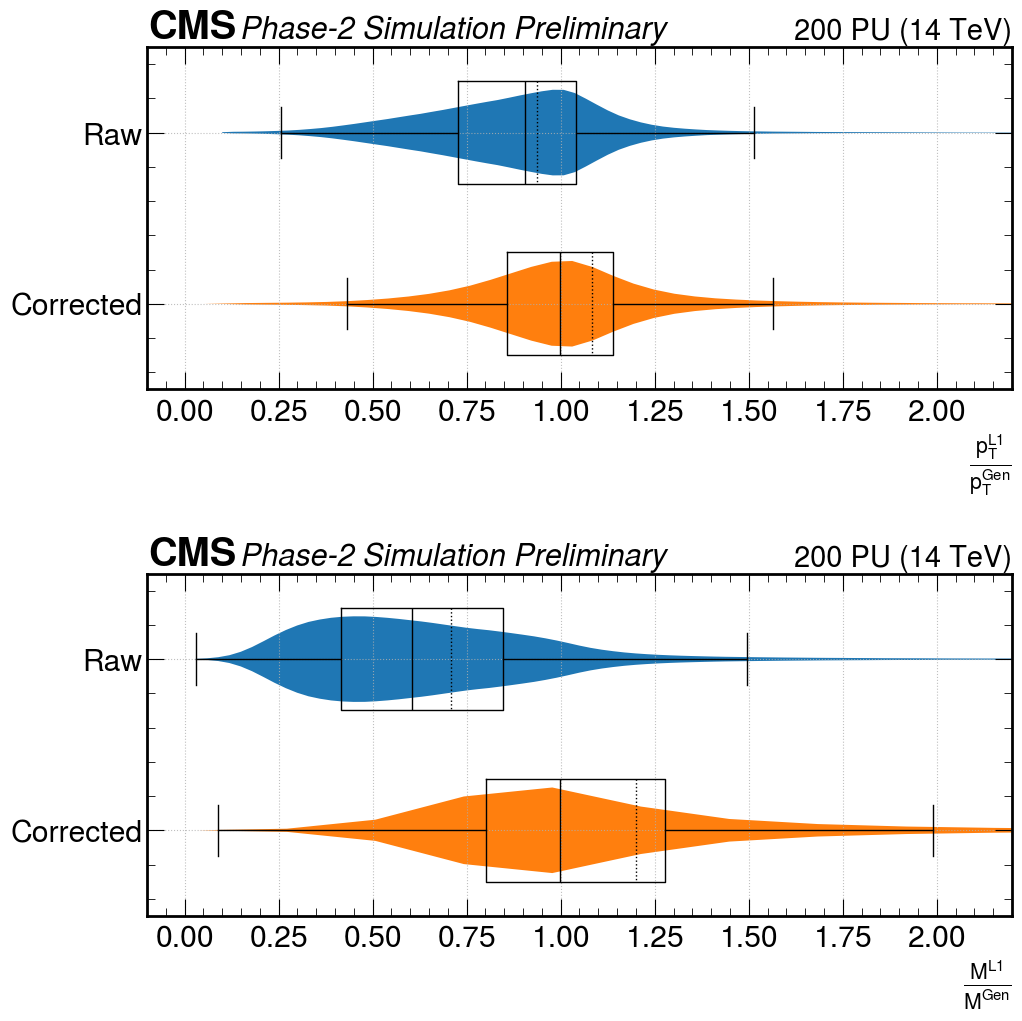

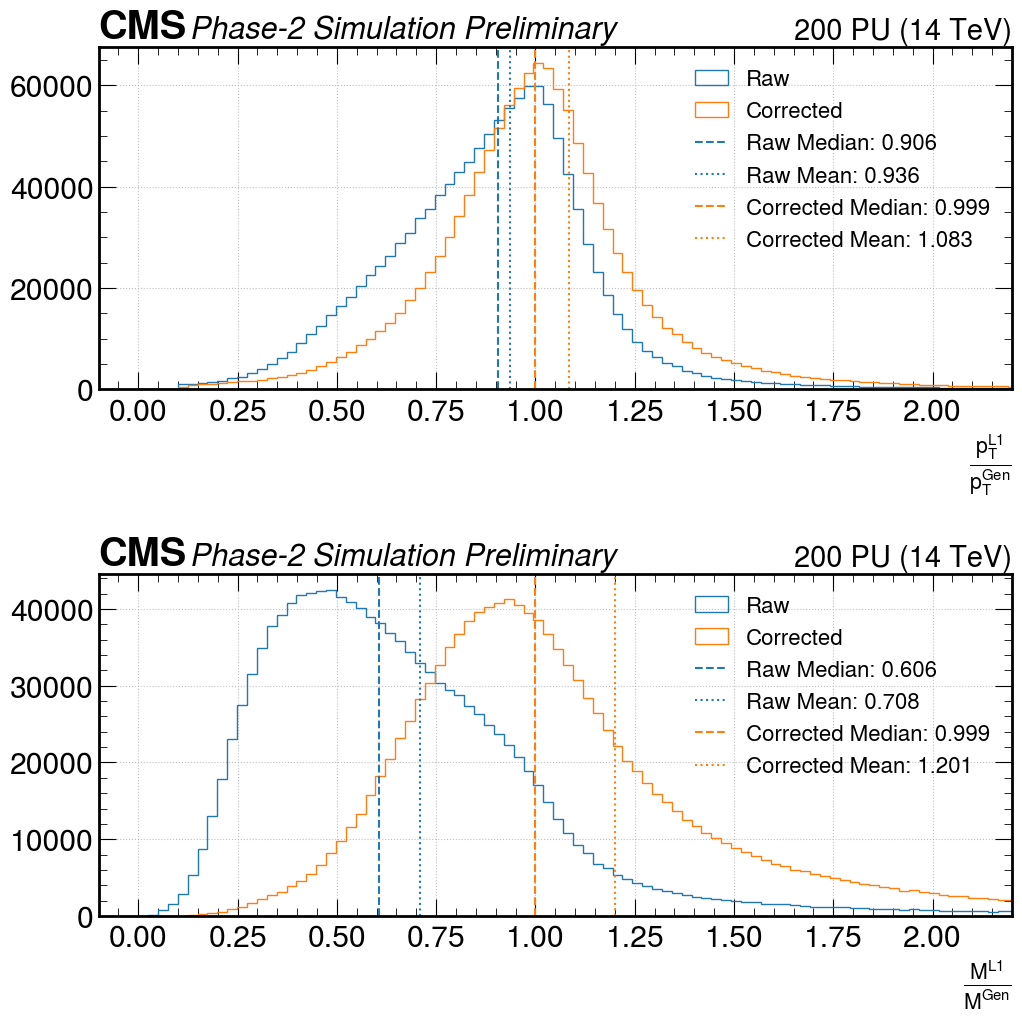

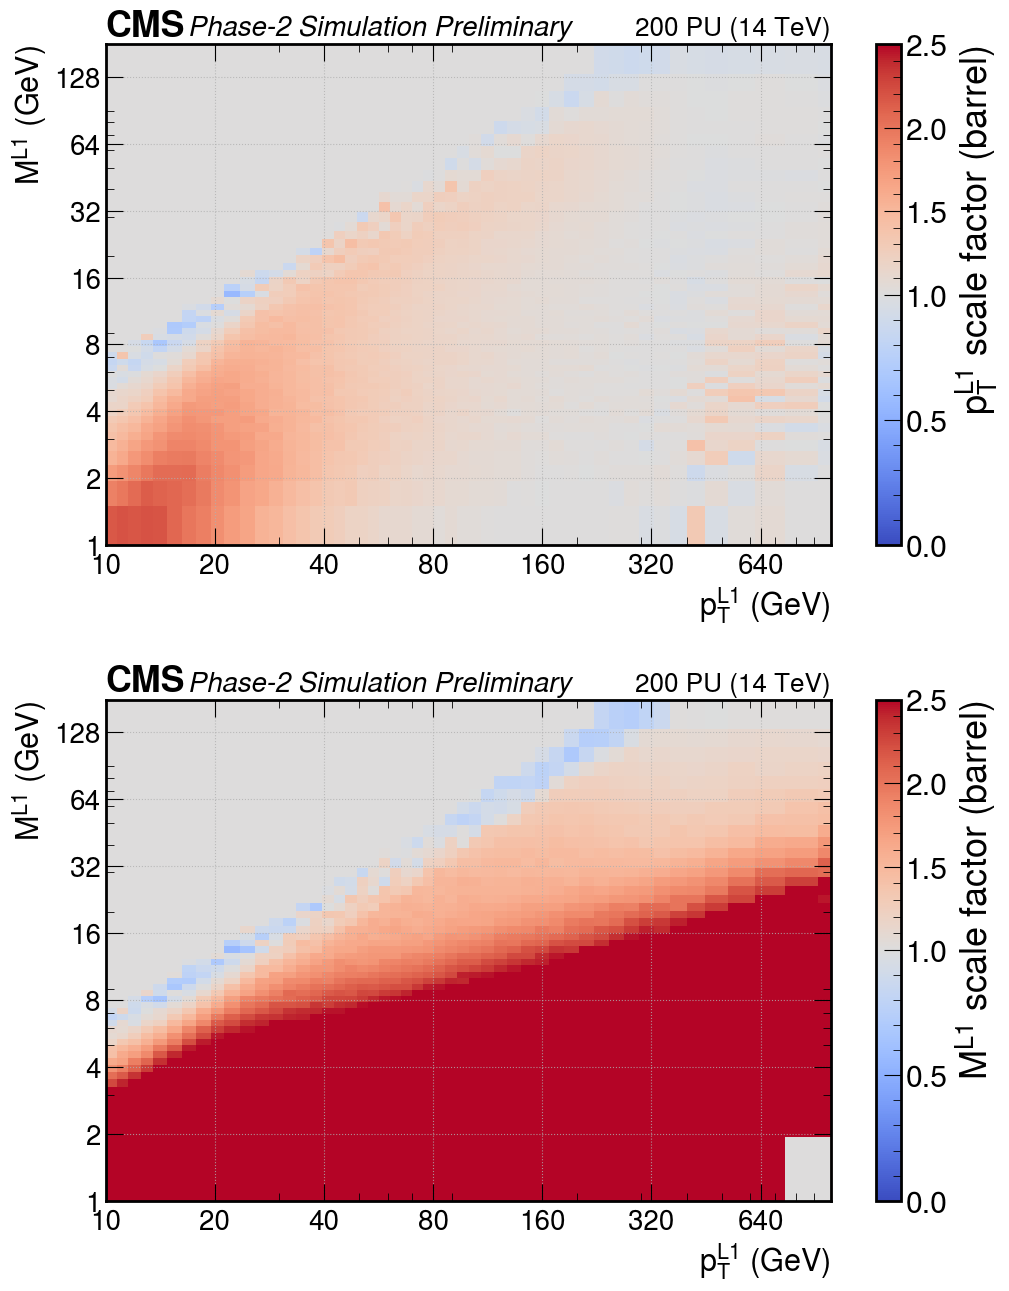

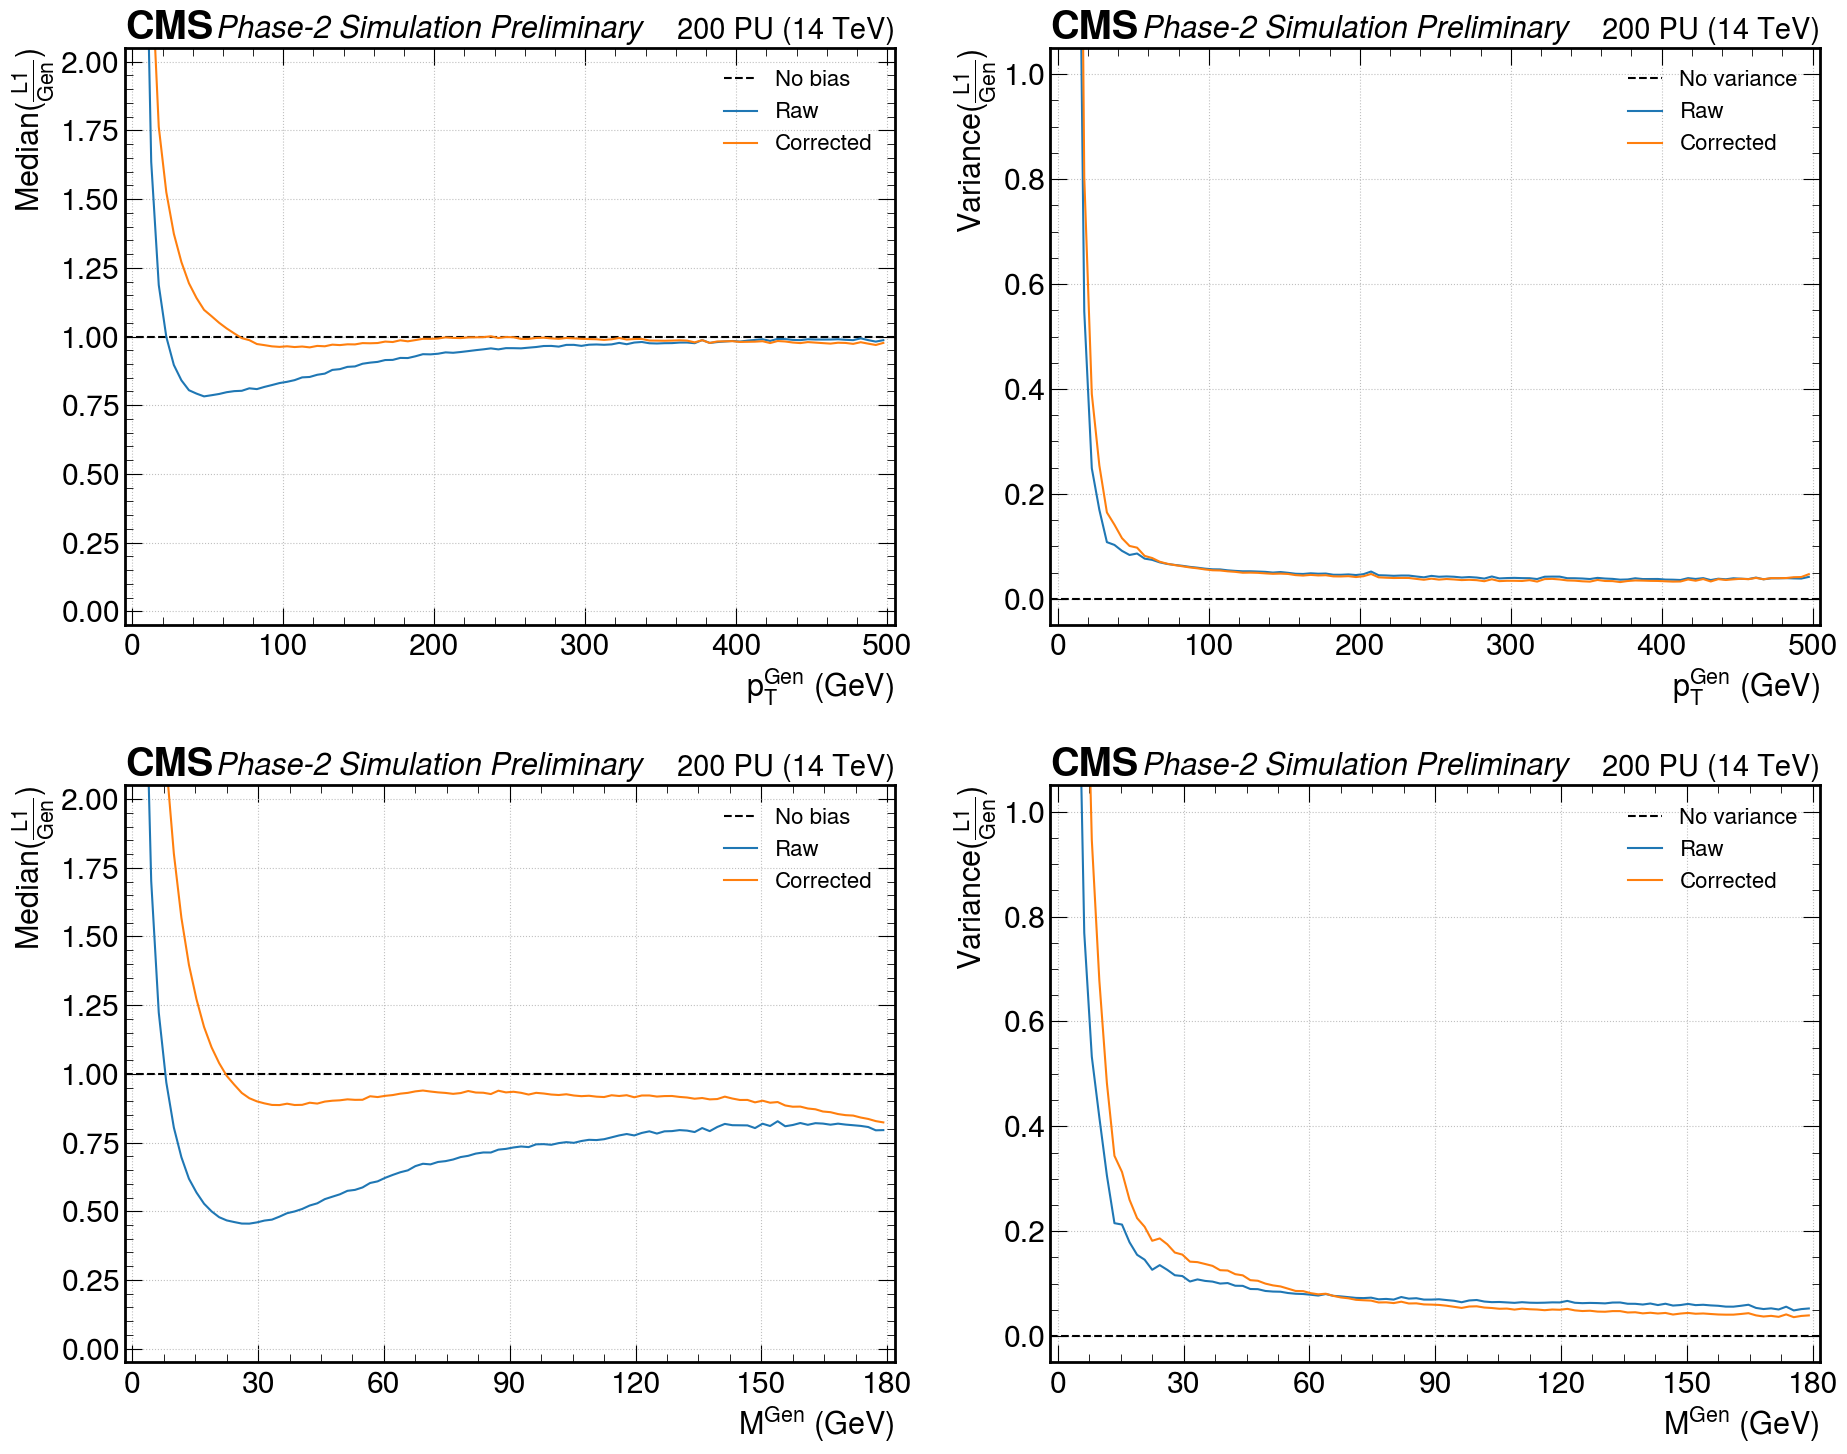

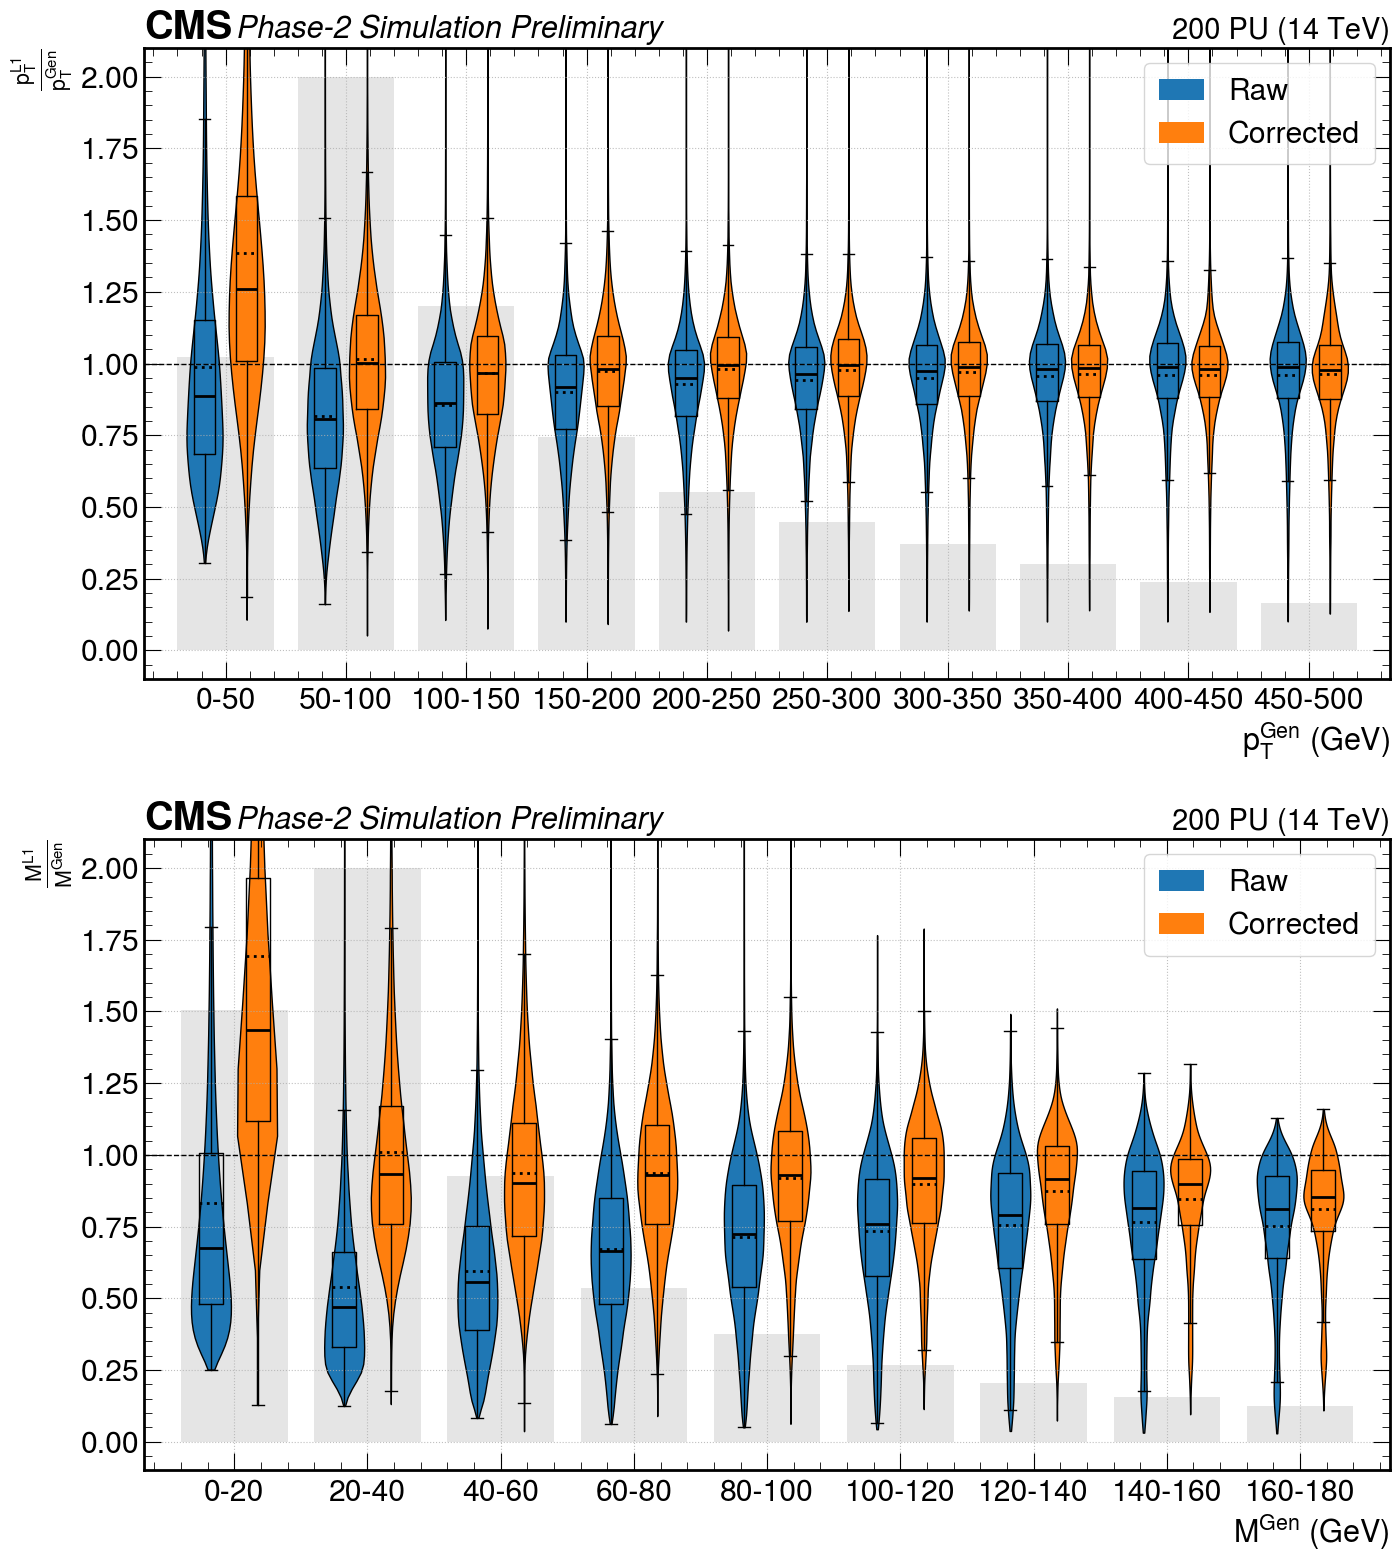

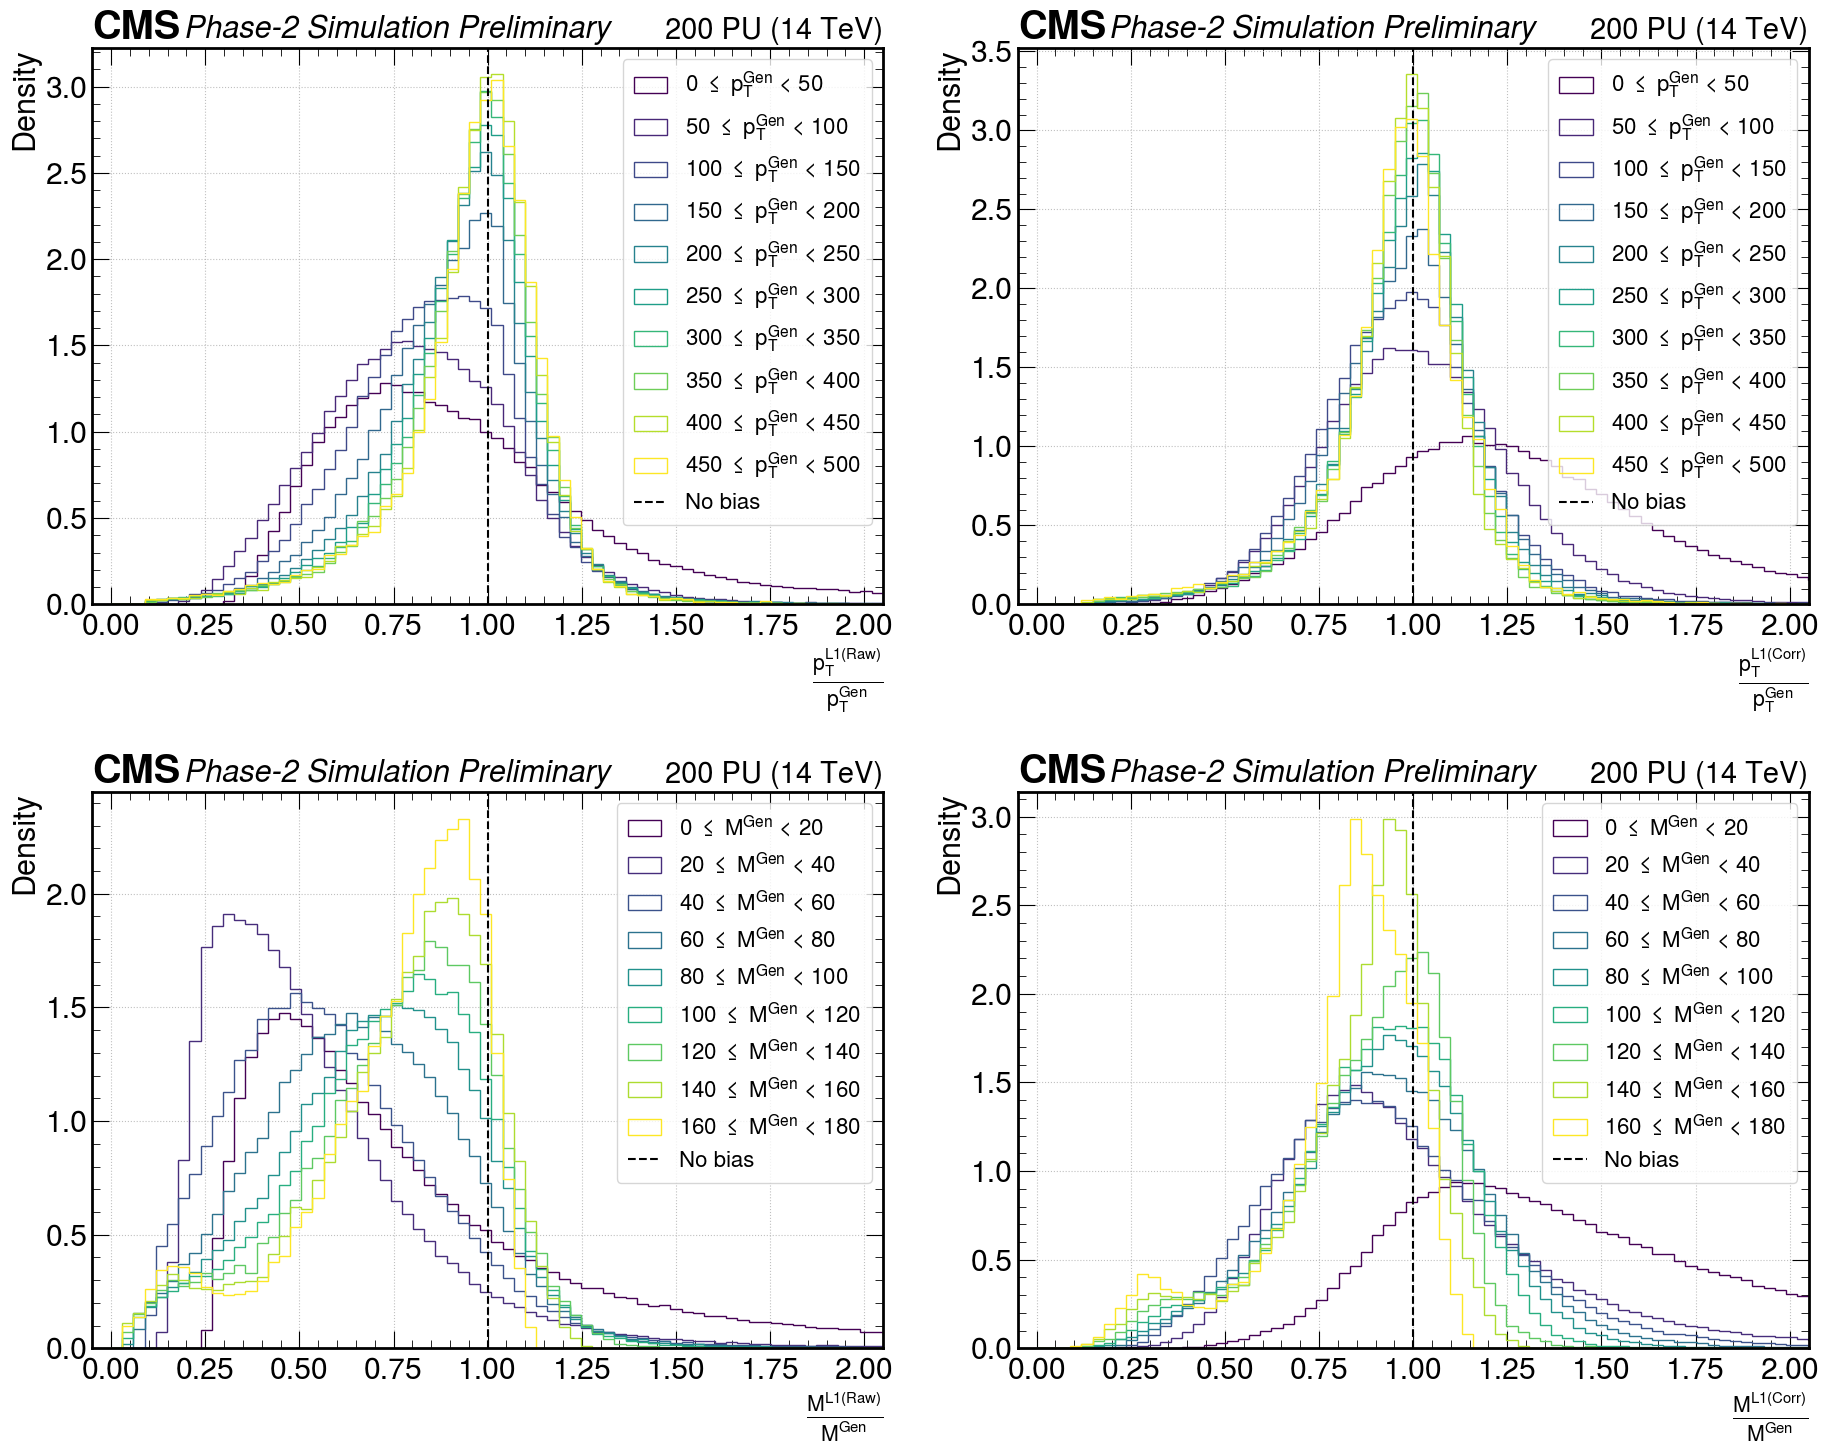

In [445]:
thresholds = Thresholds(l1_pt = (15., 2047), l1_mass=(5., 181.), gen_pt = (1., 2047.), gen_mass = (1., 181.))
plots = Plot(test, scale_factors, thresholds)
plots.make_plots()

# Performance on TT

In [263]:
tt_path = "./data/TT_PU200.root"
tt = Jet(tt_path)
pt_sfs, mass_sfs, edges, cnts = scale_factors
tt_corr = Jet.apply_scale_factors(tt.data, scale_factors)[0]
# tt.data["pt_corr"], tt.data["mass_corr"] = corrs[0], corrs[1]

Loading data...
Data loaded!



/dice/users/wq22321/jet_mass_corrections/.env/lib64/python3.9/site-packages/awkward/_nplikes/array_module.py:285: RuntimeWarning: divide by zero encountered in divide
  return impl(*broadcasted_args, **(kwargs or {}))
/dice/users/wq22321/jet_mass_corrections/.env/lib64/python3.9/site-packages/awkward/_nplikes/array_module.py:285: RuntimeWarning: invalid value encountered in divide
  return impl(*broadcasted_args, **(kwargs or {}))
/tmp/ipykernel_25566/3591607299.py:70: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend()


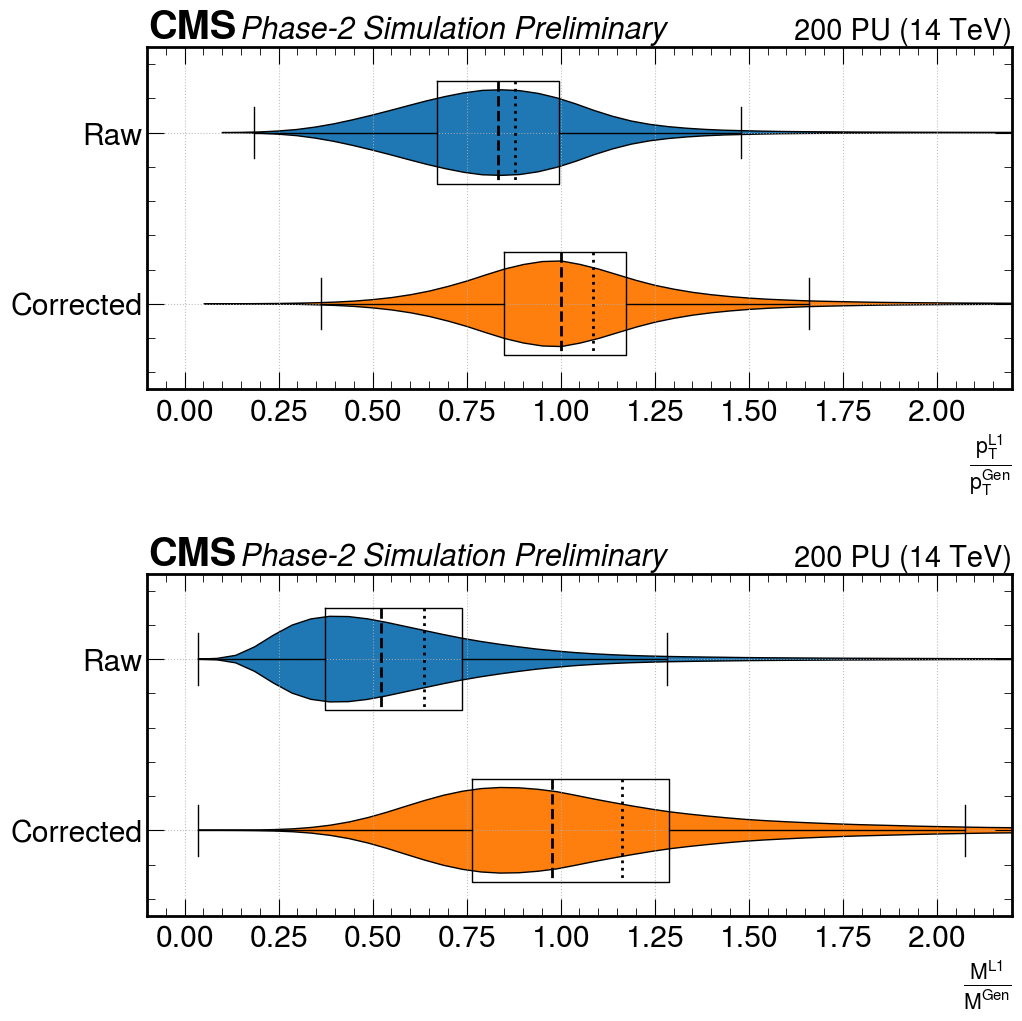

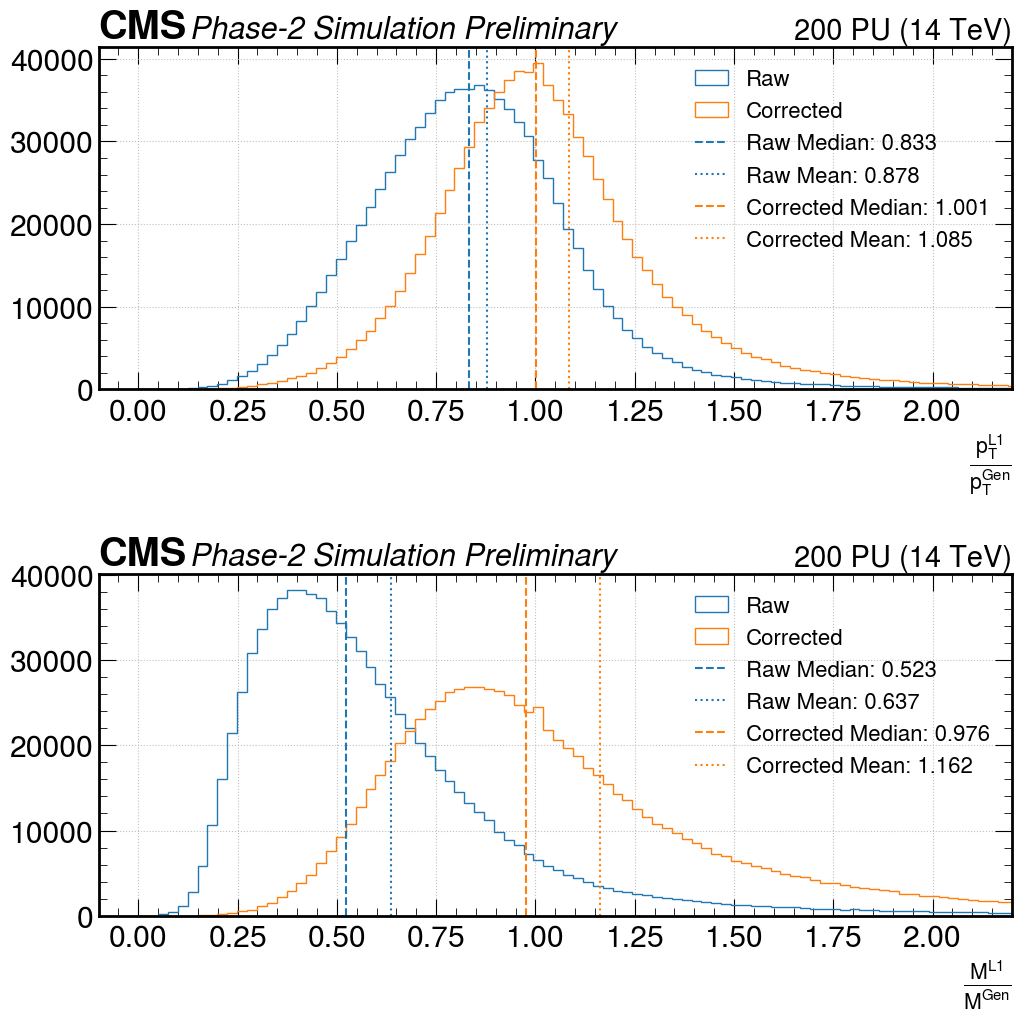

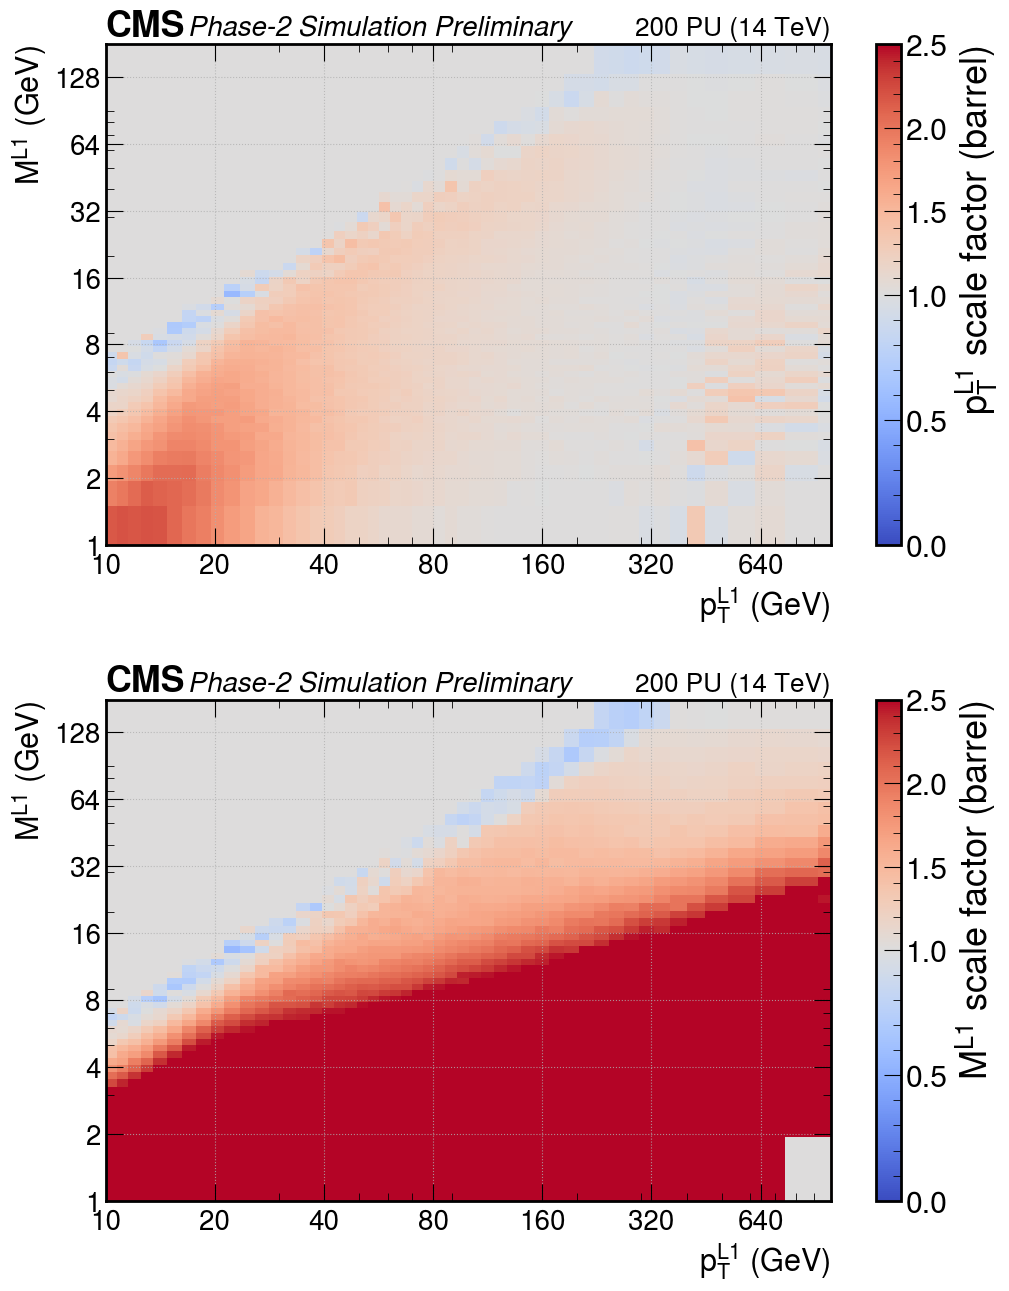

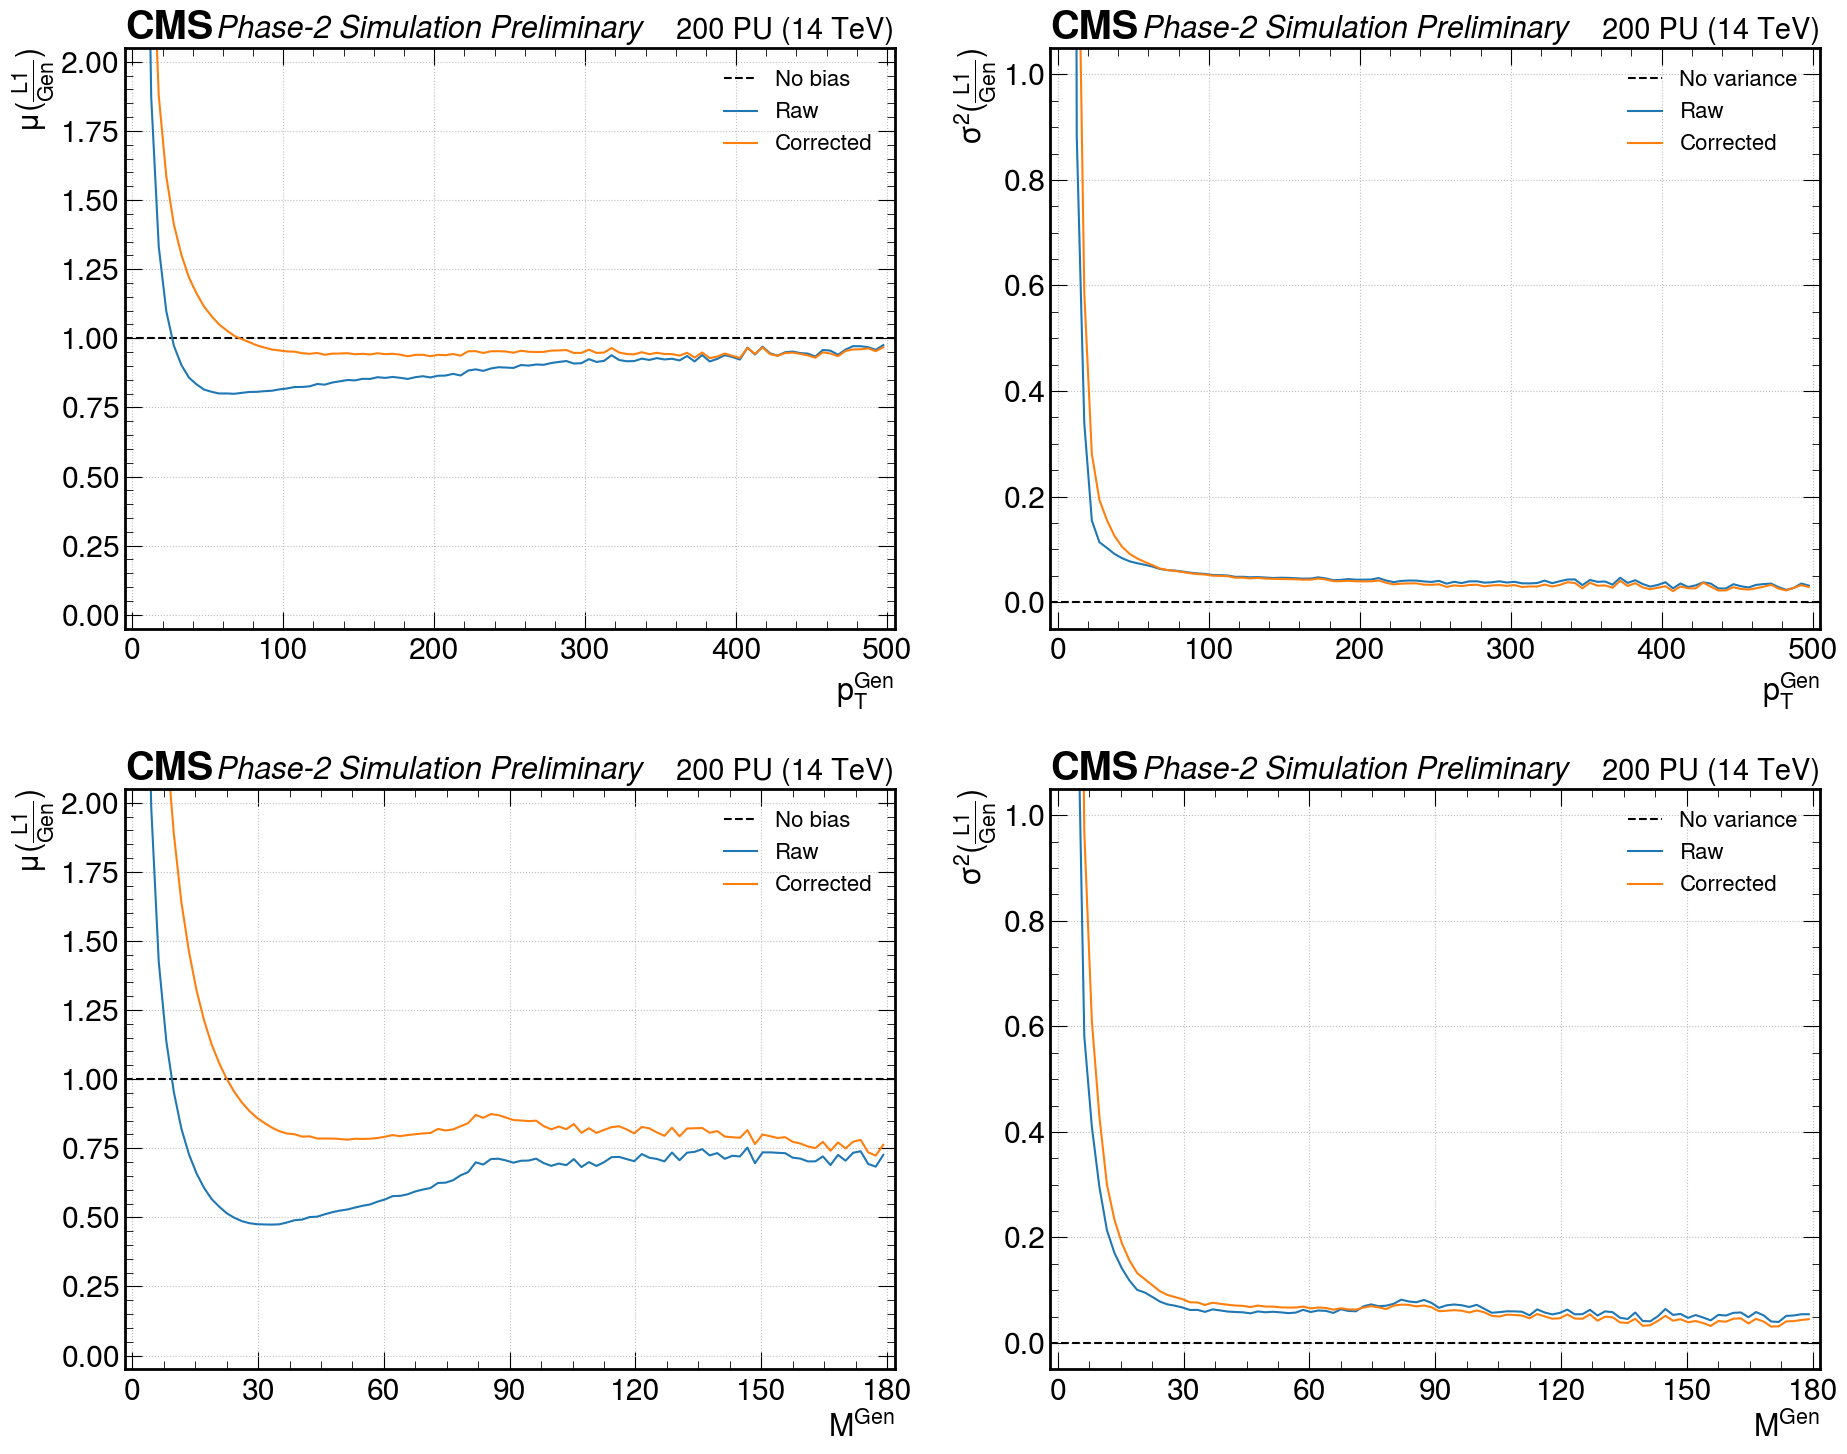

In [264]:
Plot(tt_corr, scale_factors, thresholds).make_plots()

In [ ]:
tt_leading = ak.firsts(groupby_event(tt.data))
tt_leading_corrs = Jet.apply_scale_factors(tt_leading, pt_sfs, mass_sfs, edges)
tt_leading["pt_corr"], tt_leading["mass_corr"] = tt_leading_corrs[1], tt_leading_corrs[2]

/dice/users/wq22321/jet_mass_corrections/.env/lib64/python3.9/site-packages/awkward/_nplikes/array_module.py:285: RuntimeWarning: divide by zero encountered in divide
  return impl(*broadcasted_args, **(kwargs or {}))
/dice/users/wq22321/jet_mass_corrections/.env/lib64/python3.9/site-packages/awkward/_nplikes/array_module.py:285: RuntimeWarning: invalid value encountered in divide
  return impl(*broadcasted_args, **(kwargs or {}))


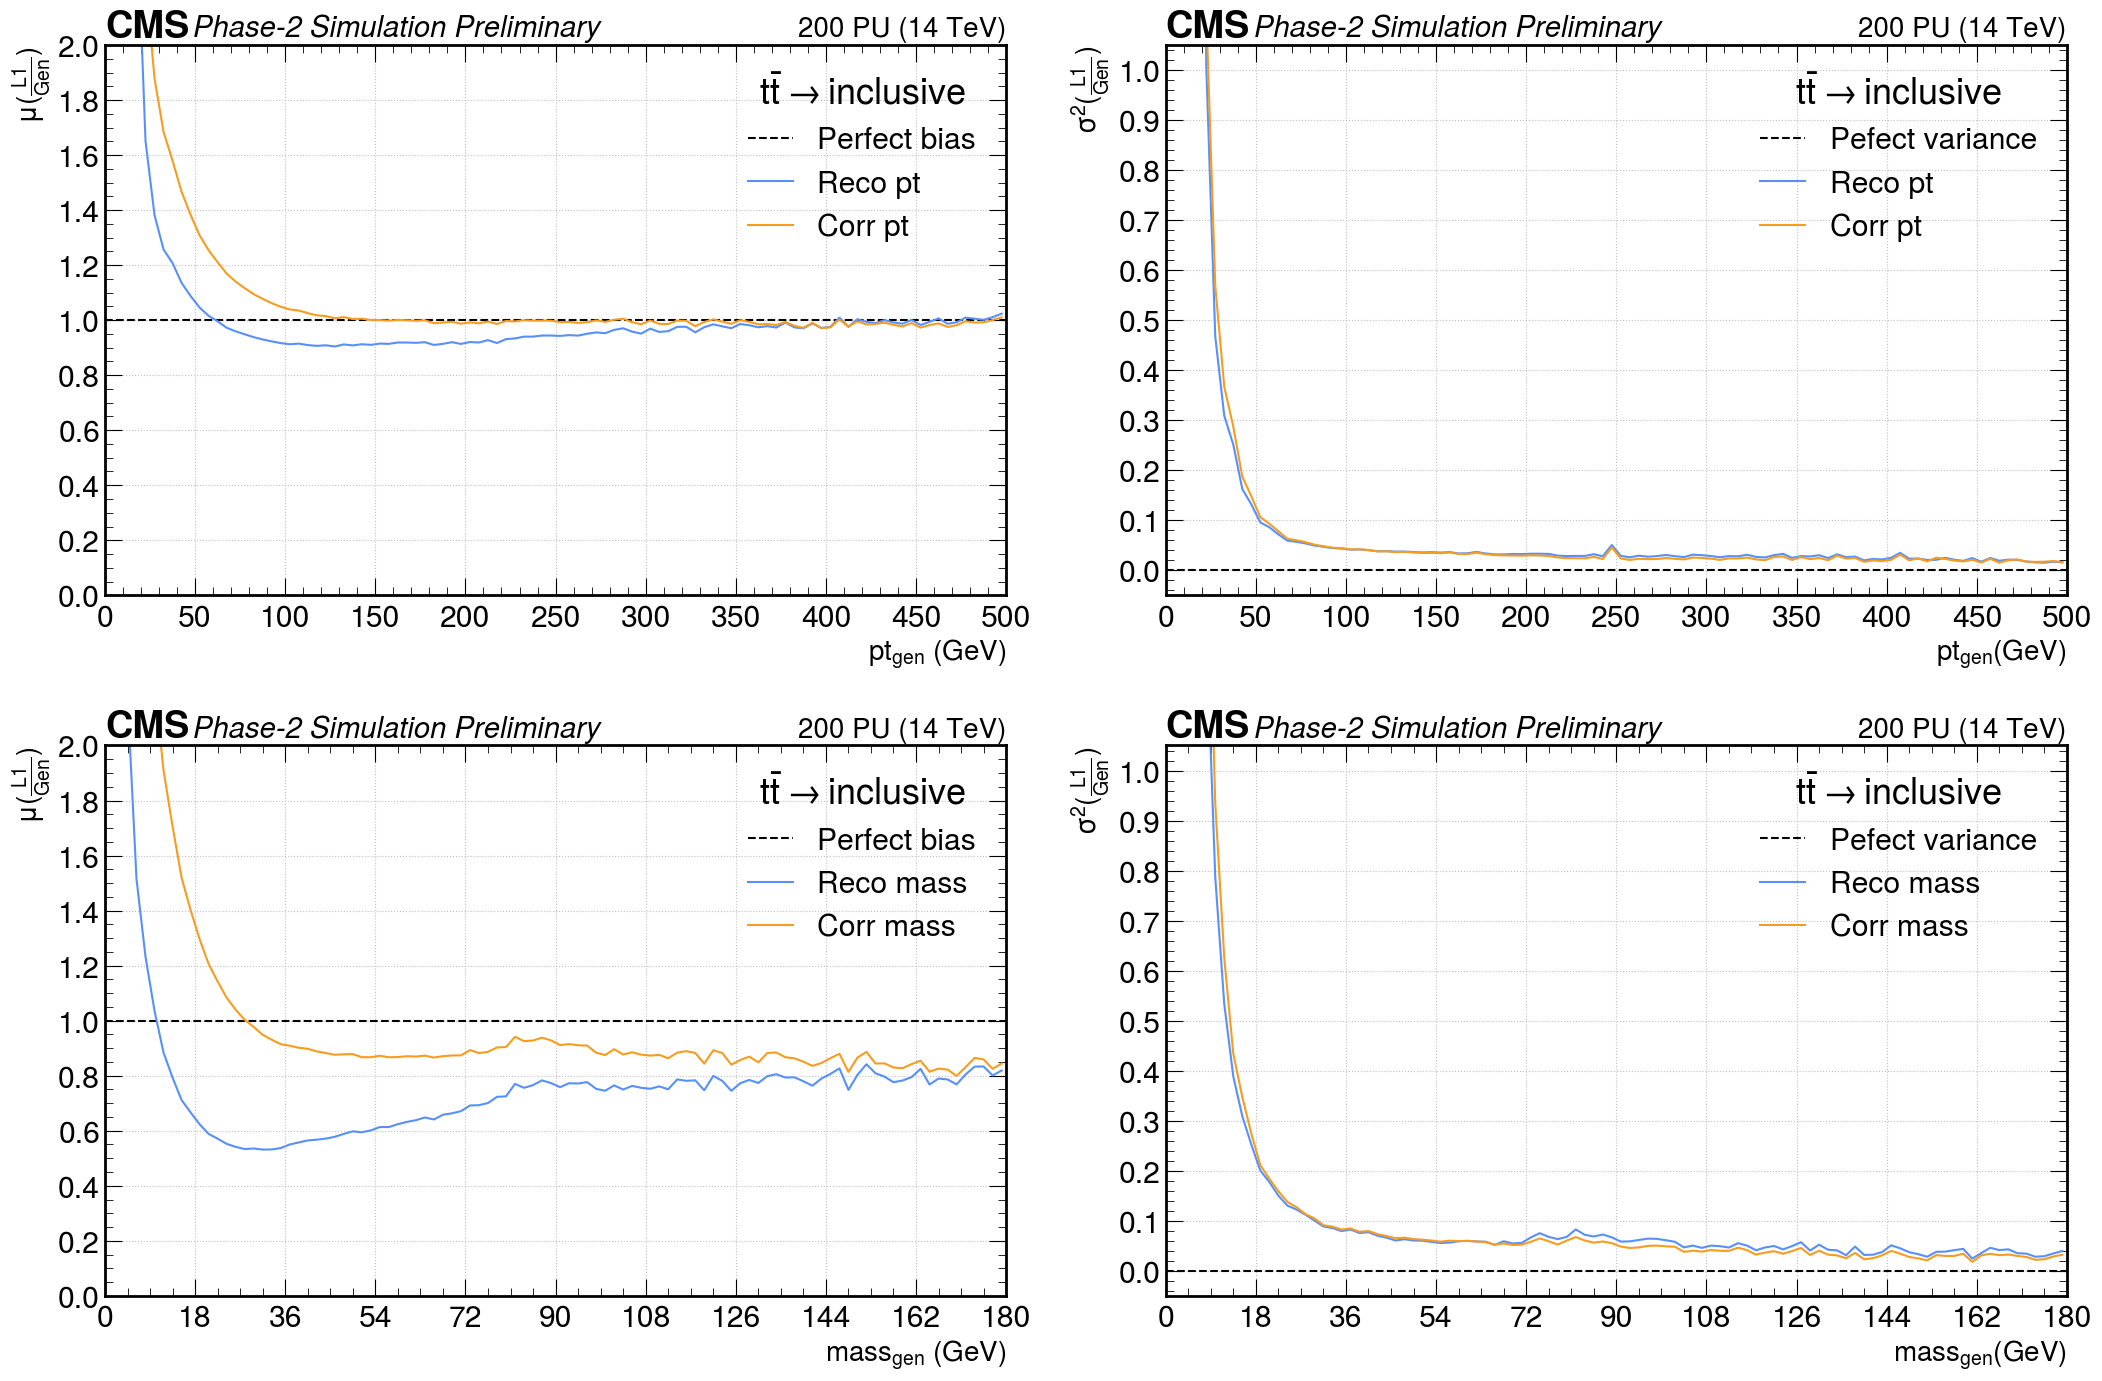

In [ ]:
plotResp(tt_leading, sample=r"$t\bar{t} \rightarrow \text{inclusive}$")

# FREFFs

In [ ]:
keys = {"L1puppiJetSC8_pt": "pt", "L1puppiJetSC8_eta": "eta", "L1puppiJetSC8_mass": "mass", "L1puppiJetSC8_genpt": "genpt", "L1puppiJetSC8_genmass": "genmass", "event": "event"}
mb_path = "/dice/users/wq22321/jet_mass_DPN/analysis/data/output_Phase2_L1T.root"
mb_jets = Jet(mb_path, branch="Events", keys = keys)
nEvents = len(mb_jets.data)
mb_leading = ak.firsts(mb_jets.data[["pt", "eta", "mass"]])
mb_leading["pt_corr"], mb_leading["mass_corr"] = mb_jets.apply_scale_factors(mb_leading, pt_sfs, mass_sfs, edges)

In [ ]:
def get_rate(bkg_leading, pt_threshold, mass_threshold, nEvents, corrected=False):
    pt_var, mass_var = ("pt_corr", "mass_corr") if corrected else ("pt", "mass")
    passed_mask = (bkg_leading[pt_var] > pt_threshold) & (bkg_leading[mass_var] > mass_threshold)
    K = 40000000 * (2750 / 3564)
    return K * ( ak.sum(passed_mask) / nEvents )

In [ ]:
def get_eff(sig_leading, pt_threshold, mass_threshold, corrected=False):
    pt_var, mass_var = ("pt_corr", "mass_corr") if corrected else ("pt", "mass")
    mask = (sig_leading[pt_var] > pt_threshold) & (sig_leading[mass_var] > mass_threshold)
    return ak.sum(mask) / len(sig_leading)

In [ ]:
keys = {"L1puppiJetSC8_pt": "pt", "L1puppiJetSC8_eta": "eta", "L1puppiJetSC8_mass": "mass", "L1puppiJetSC8_genpt": "genpt", "L1puppiJetSC8_genmass": "genmass", "event": "event"}
MH40 = "/dice/users/wq22321/jet_mass_DPN/analysis/data/signal/XtoHH_MH-40_qq_PU200_signal.root"
sig_jets = Jet(MH40, branch="Events", keys = keys)
sig_leading = ak.firsts(sig_jets.data[["pt", "eta", "mass", "genpt", "genmass"]])
sig_leading["pt_corr"], sig_leading["mass_corr"] = sig_jets.apply_scale_factors(sig_leading, pt_sfs, mass_sfs, edges)

In [ ]:
from scipy.optimize import differential_evolution as de

# Your objective function
def find_optimum_corr_thresholds(bkg, sig, nEvents, pt_thresh, mass_thresh):
    rate = get_rate(bkg, pt_thresh, mass_thresh, nEvents, corrected=True)
    if rate > 50000:   # penalty for exceeding 50 kHz
        return 0       # any positive value is fine
    else:
        eff = get_eff(sig, pt_thresh, mass_thresh, corrected=True)
        return -eff     # DE minimises, so invert

# Wrapper for DE (must take a single vector argument)
def opti_wrapper(params):
    pt_thresh, mass_thresh = params
    return find_optimum_corr_thresholds(
        mb_leading, sig_leading, nEvents,
        pt_thresh, mass_thresh
    )

# ---- SET BOUNDS ----
# Adjust these depending on your real ranges
pt_bounds = (0, 200)        # e.g. pt threshold from 0–200 GeV
mass_bounds = (0, 50)      # e.g. mass threshold from 0–200 GeV
bounds = [pt_bounds, mass_bounds]

# ---- RUN OPTIMISATION ----
opti_result = de(opti_wrapper, bounds=bounds)

print("Optimisation result:", opti_result)
print("Best pt_thresh:", opti_result.x[0])
print("Best mass_thresh:", opti_result.x[1])
print("Efficiency achieved:", -opti_result.fun * 100, "%")

raw_eff = get_eff(sig_leading, 111, 21, corrected=False)

if raw_eff < -opti_result.fun:
    print("CORRECTIONs RESULT IN IMPROVED L1T EFFICIENCY:")
print(f"Improvement: {(opti_result.fun - raw_eff):.4f}%")

In [ ]:
from collections import namedtuple
Value = namedtuple("Value", "value error")
def get_turnon(mask, gen, nBins, upperLim=500, equal_frequency=False, custom_bins=None, eta_sep = 100):
    
    if equal_frequency and custom_bins is None:
        _, bins = pd.qcut(gen.to_numpy(allow_missing=True), q=nBins, retbins=True)
        bins[0] = 0
        bins[-1] = upperLim
    elif custom_bins is not None and equal_frequency is False:
        bins = custom_bins
    elif custom_bins is not None and equal_frequency:
        raise Exception("Cannot set both equal_frequency and custom_bins!")
    else:
        bins = np.linspace(0, upperLim, nBins+1)

    effs = []
    for b in range(len(bins)-1):
        inBinMask = (gen >= bins[b]) & (gen < bins[b+1])
        denominator = ak.sum(inBinMask)
        if denominator > 1:
            eff = ak.sum( mask[inBinMask] ) / denominator
            err = np.sqrt(eff * (1 - eff) / denominator)
        else:
            eff = np.float64(0)
            err = np.float64(0)
        effs.append( Value(eff, err) )

    return bins, np.array(effs), np.histogram(gen, int(upperLim/10), range=(0, upperLim))

In [ ]:
def plot_turnon(bins, counts, formatting, **effs):
    xs = bins[:-1] + np.diff(bins)/2
    xerrs = np.diff(bins)/2  # symmetric left/right errors
    counts, countBins = counts[0], counts[1]
    widths = np.diff(countBins)
    cents = countBins[:-1] + widths/2
    
    plt.figure(figsize=(15,12))
    plt.bar(cents, 100*counts/max(counts), color="black", alpha=0.1, width=widths)
    for idx, (label, eff) in enumerate(effs.items()):
        plt.errorbar(
            x = xs, y = eff[:, 0]*100, xerr=xerrs, yerr = eff[:, 1]*100,
            fmt="-o", capsize=5, label=formatting[label][0], color=formatting[label][1], markersize=12, linewidth=2, linestyle=formatting[label][2], marker=formatting[label][3]
            )
    
    hep.cms.label(llabel="Phase-2 Simulation Preliminary", rlabel="200 PU (14 TeV)", fontsize=32)
    plt.xlabel(formatting["xlabel"], fontsize=32)
    plt.ylabel(formatting["ylabel"], fontsize=32)
    plt.ylim([-5, 105])
    plt.yticks(np.linspace(0,100,11), fontsize=27)
    plt.xticks(np.linspace(0, bins[-1], 11), fontsize=27)
    plt.legend(loc="center right", title=formatting["sample"], fontsize=27, title_fontsize=32)
    # plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    # plt.text(x=300, y=3, s = formatting["sample"])
    plt.grid()
    plt.show()

In [ ]:
""" SINGLE PF JET - MH40 """
gen = sig_leading["genpt"]
nBins = 16
bins = [0, 25, 40, 55, 70, 85, 95, 105, 115, 125, 135, 150, 165, 190, 240, 320, 500]

labels = {
    "raw": ("Raw\n$p_{T, leading}$ > 111 GeV\n$M_{leading}$ > 21 GeV", "#ffa90e", "dashdot", "s"),
    "corr": ("Corrected\n$p_{{T, leading}}$ > {pt_thresh:.0f} GeV\n$M_{{leading}}$ > {mass_thresh:.0f} GeV".format(pt_thresh=opti_result.x[0], mass_thresh = opti_result.x[1]), "#832db6", "dashed", "^"),

    "xlabel": "Leading AK8 Gen Jet $p_T$ (GeV)",
    "ylabel": "Level-1 efficiency @ 50 kHz (%)",
    "sample": r"$X_{M=300} \rightarrow hh_{M=40} \rightarrow q\bar{q}/gg$"
}

mask_raw = (sig_leading.pt > 111) & (sig_leading.mass > 21)
mask_corr = (sig_leading.pt_corr > opti_result.x[0]) & (sig_leading.mass_corr > opti_result.x[1])

bins, effs_raw, _ = get_turnon(mask_raw, gen, nBins, upperLim=500, equal_frequency=False, custom_bins=bins, eta_sep = 5)
_, effs_corr, _ = get_turnon(mask_corr, gen, nBins, upperLim=500, equal_frequency=False, custom_bins=bins, eta_sep = 5)
plot_turnon(bins, _, labels, raw=effs_raw, corr=effs_corr)